In [1]:
import pandas as pd
import torch 
import numpy as np

ModuleNotFoundError: No module named 'torch'

Custom Functions

In [61]:
def integrate_scene(df, trajectory_dict):
    scene = {}
    flag = ""
    
    for ind in df.index:
        scene_key = str(df['sceneId'][ind])
        track_key = str(df['uniqueTrackId'][ind])
        if flag == track_key:
            continue
        if scene_key not in scene:
            scene[scene_key] = [{track_key : trajectory_dict.get(track_key)}]
            flag = track_key
            continue
        scene[scene_key].append({track_key : trajectory_dict.get(track_key)})
        flag = track_key
    return scene

Reading complete trajectories from file_all_pedestrian.csv

In [62]:
data = pd.read_csv("/home/shayan/Desktop/Trajectory_inpainting/data/file_all_pedestrian.csv")

complete_trajectories = {}

for ind in data.index:
    track_key = str(data['uniqueTrackId'][ind])
    coordinate = (data['sceneX'][ind],data['sceneY'][ind])
    
    if track_key not in complete_trajectories:
        complete_trajectories[track_key] = torch.tensor([coordinate])
        continue
        
    complete_trajectories[track_key] = torch.cat((complete_trajectories[track_key], torch.tensor([coordinate])))
    

Adding trackIDs into their corresponding scenes

In [63]:
complete_trajectories_scene = integrate_scene(data, complete_trajectories)

In [64]:
complete_trajectories_scene['330']

[{'32138': tensor([[-0.3594, -2.9867],
          [-0.4377, -2.8560],
          [-0.5155, -2.7204],
          [-0.5917, -2.5798],
          [-0.6661, -2.4368],
          [-0.7380, -2.2922],
          [-0.8079, -2.1460],
          [-0.8760, -1.9977],
          [-0.9425, -1.8479],
          [-1.0065, -1.6981],
          [-1.0693, -1.5497],
          [-1.1305, -1.4031],
          [-1.1899, -1.2574],
          [-1.2487, -1.1125],
          [-1.3057, -0.9692],
          [-1.3609, -0.8274],
          [-1.4148, -0.6860],
          [-1.4682, -0.5446],
          [-1.5213, -0.4032],
          [-1.5733, -0.2628],
          [-1.6240, -0.1245],
          [-1.6739,  0.0123],
          [-1.7247,  0.1443],
          [-1.7752,  0.2751],
          [-1.8255,  0.4045],
          [-1.8749,  0.5323],
          [-1.9234,  0.6587],
          [-1.9718,  0.7847],
          [-2.0211,  0.9114],
          [-2.0714,  1.0385],
          [-2.1220,  1.1645],
          [-2.1732,  1.2895],
          [-2.2245,  1.4142],
 

Making incomplete trajectories from the prev cell with a user defined masking ratio

In [65]:
import random
masking_ratio = .20 #represents the percentage of data points we want to mask in each trajectory

incomplete_trajectories = {}
for track_id in complete_trajectories:
    track_size = len(complete_trajectories[track_id])
    track_point_delete_size = int(masking_ratio * track_size) # as the masking ratio is in percentage
    # print(track_point_delete_size)
    starting_point_to_dlt = random.randint(0, track_size - track_point_delete_size)
    # print( starting_index_point_delete )
    # tres = track_size - starting_point_to_dlt
    tres = starting_point_to_dlt + track_point_delete_size - 1
    if track_id not in incomplete_trajectories:
        incomplete_trajectories[track_id] = torch.cat((complete_trajectories[track_id][0:starting_point_to_dlt], complete_trajectories[track_id][tres:]))
        complete_trajectories[track_id] = complete_trajectories[track_id][starting_point_to_dlt : tres+1]        
        continue
    incomplete_trajectories[track_id].cat((complete_trajectories[track_id][0:starting_point_to_dlt],
                                           complete_trajectories[track_id][tres:]))
    complete_trajectories[track_id] = complete_trajectories[track_id][starting_point_to_dlt : tres + 1]        
    

Re-assigning scenes to incomplete trajectories

In [66]:
incomplete_trajectories_scene = integrate_scene(data, incomplete_trajectories)

Visualizing by scenes

Scene ID: 330


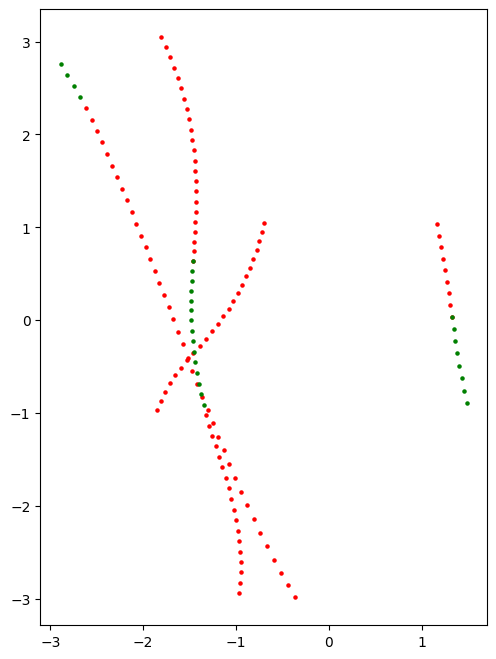

Scene ID: 231


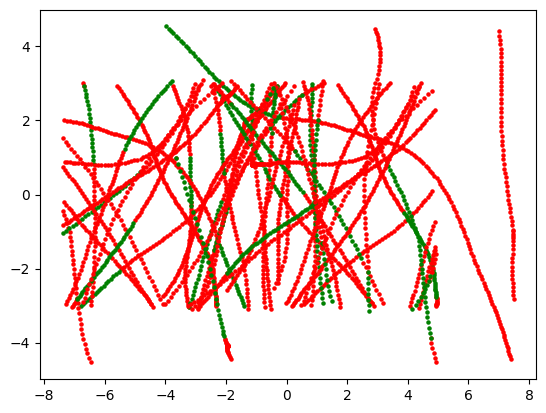

Scene ID: 222


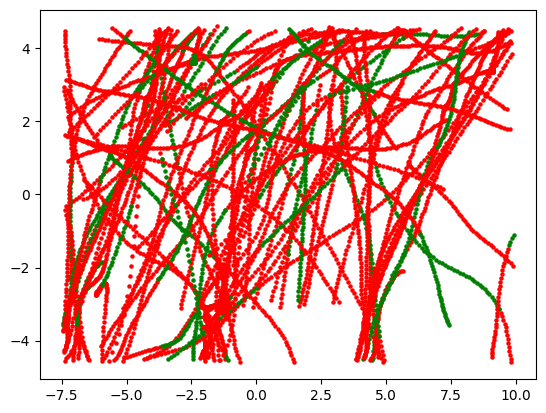

Scene ID: 340


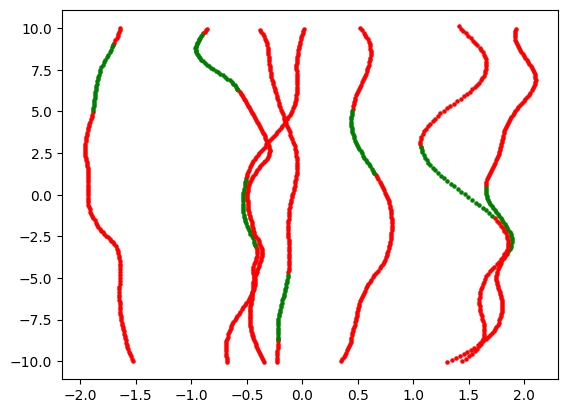

Scene ID: 221


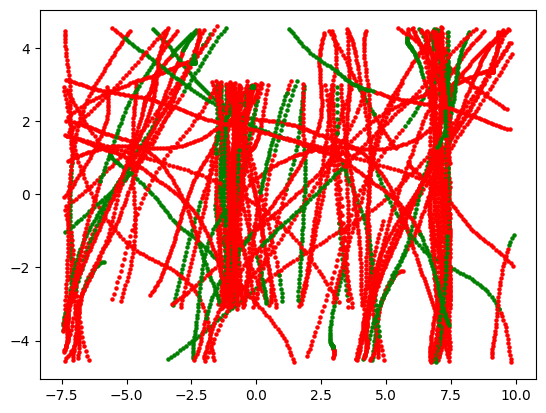

Scene ID: 131


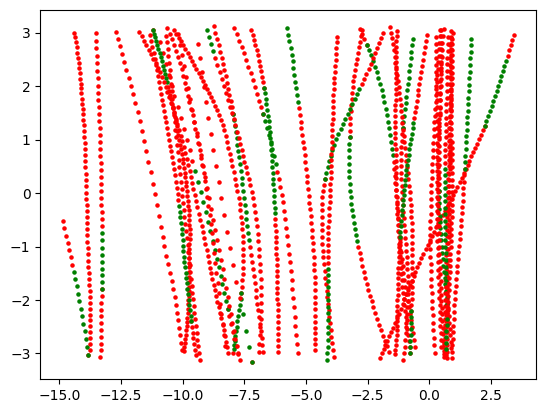

Scene ID: 130


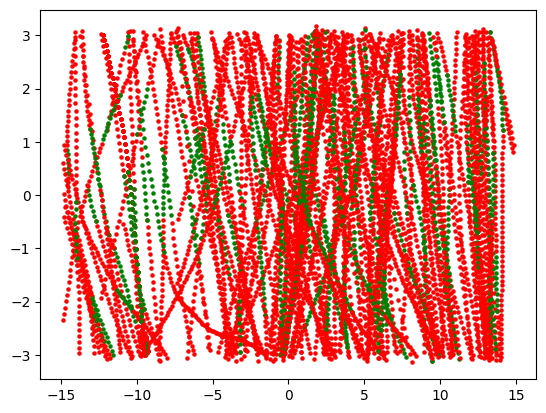

Scene ID: 230


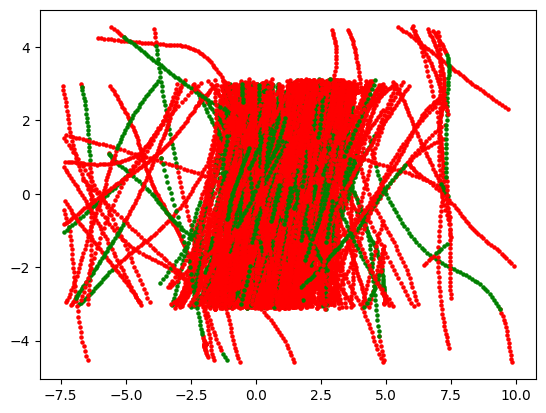

Scene ID: 331


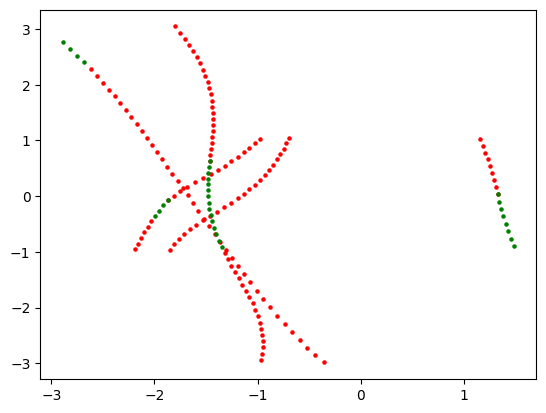

Scene ID: 240


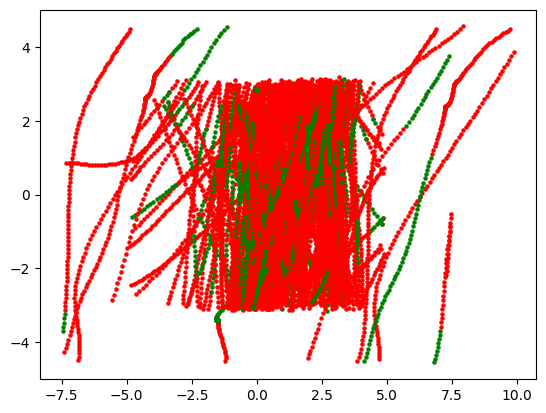

Scene ID: 210


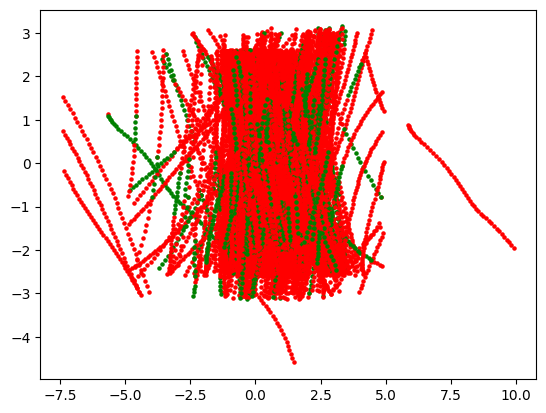

Scene ID: 211


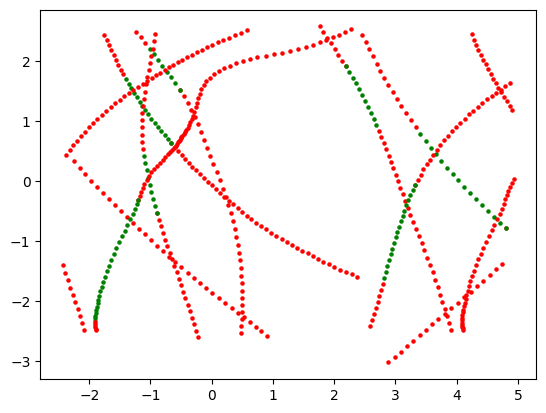

Scene ID: 440


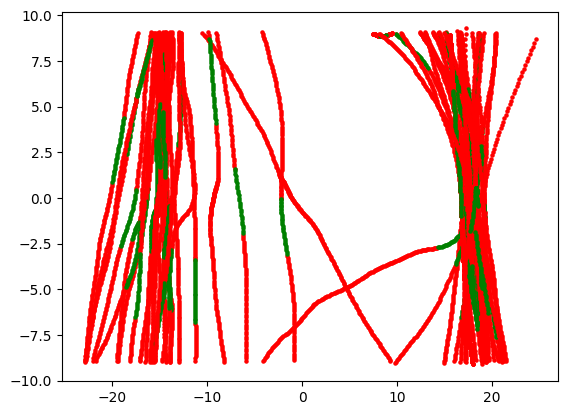

Scene ID: 120


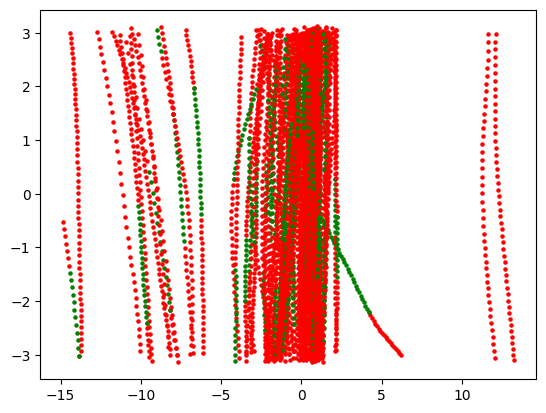

Scene ID: 140


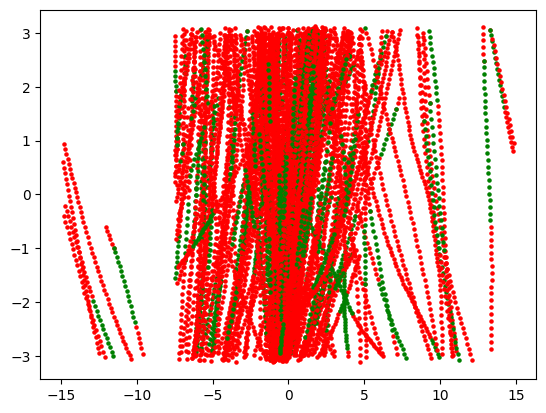

Scene ID: 430


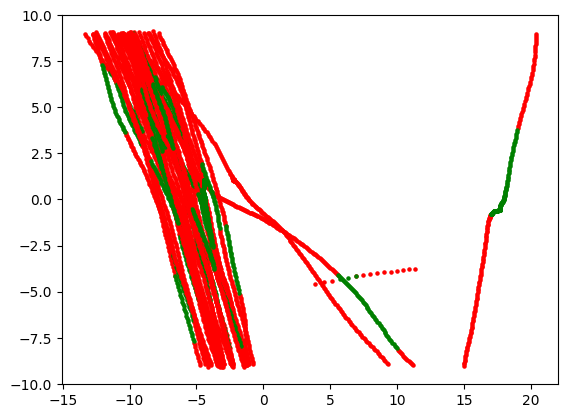

Scene ID: 441


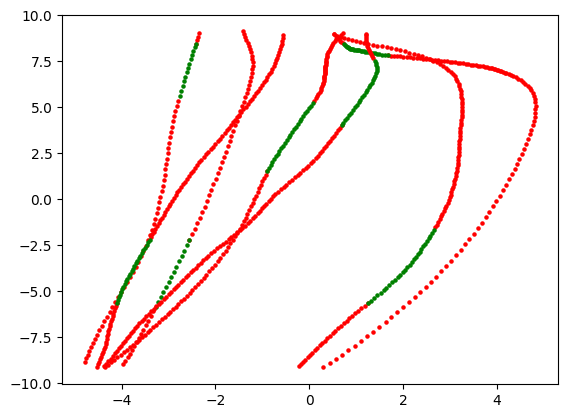

Scene ID: 220


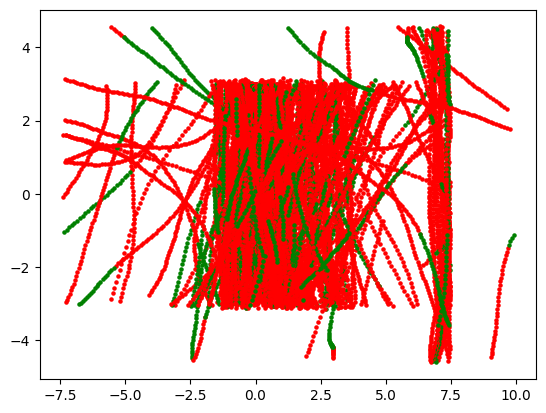

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
for key, value_list in complete_trajectories_scene.items():
    print(f"Scene ID: {key}")
    for dictionary in value_list:
        for track_id in dictionary.keys():
            plt.scatter(incomplete_trajectories[track_id][:, 0], incomplete_trajectories[track_id][:, 1], color='red',s=5)
            plt.scatter(complete_trajectories[track_id][:, 0], complete_trajectories[track_id][:, 1], color='green', s=5)
    ax.set_aspect('equal', adjustable='box')
    plt.show()